Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Crystal: Al (FCC), a = 4.05 Å
Ecut = 300.0 eV -> 11.02480 Hartree
Number of plane waves (Gamma): 181
First 8 G coefficients: [(0, 0, 0), (1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, -1), (-1, 0, 0), (-1, -1, -1)]
First 8 kinetic energies (Hartree): [0.         1.01098166 1.01098166 1.01098166 1.01098166 1.01098166
 1.01098166 1.01098166]
Cell volume (bohr^3): 112.073152
Hartree energy (Hartree): 0.01052706
Hartree energy (eV): 0.286456 eV
Largest contrib #1: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #2: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617e-02
Largest contrib #3: |n(G)|^2/|G|^2 = 1.486583e-02, |G| = 4.443617

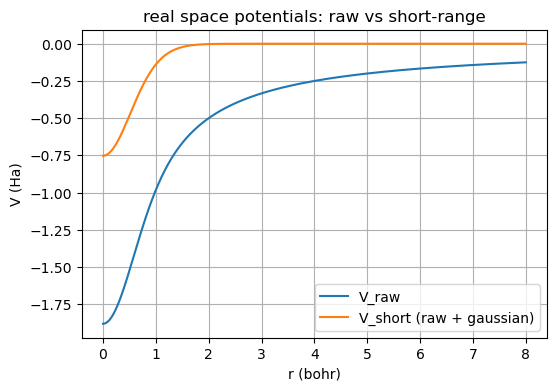

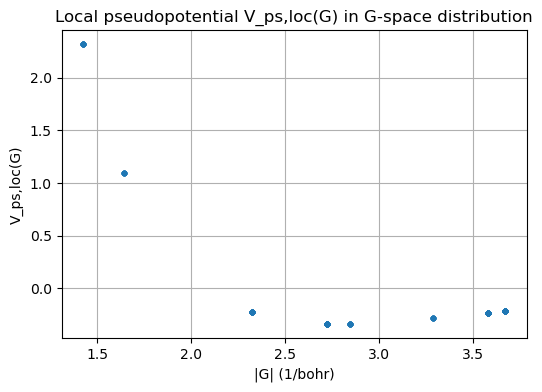

In [ ]:
# 引用已有函数（晶格/倒格子/平面波生成）
%run basis_func_with_kinetic.ipynb
%run Hartree.ipynb  # 可选：若需要 FFT/辅助函数（非必须）

import numpy as np
import matplotlib.pyplot as plt
from scipy import special

    # ---- 局域赝势分解：短/长程处理（按幻灯片方法） ----
# 目标：将 V_ps,loc(r) 分成短程部分进行 FFT/数值积分，长程高斯部分用解析式在 G 空间处理以保证大 r 数值稳定性。

# 假设存在基础函数与 generate_G_vectors 等（已通过 %run 引入）

def Vps_loc_raw(r, Z=1.0, r_c=0.5):
    """
    原始实空间局域赝势示例（可替换为实际赝势）。
    这里示例使用平滑化库仑：V(r) = -Z * erf(r/r_c)/r。
    注意：输入 r 单位为 bohr，返回单位为 Hartree（示例）
    """
    r = np.asarray(r)
    small = 1e-12
    rval = np.where(np.abs(r) < small, small, r)
    V = -Z * special.erf(rval / r_c) / rval
    V = np.where(np.abs(r) < small, -Z * 2.0/np.sqrt(np.pi) / r_c, V)
    return V

def V_short_real(r, Z=1.0, r_c=0.5, r_gau=1.0):
    """
    构造短程部分：V_short(r) = Vps_loc_raw(r) + Z/r * erf(r / r_gau)
    目的：对于大 r，Vps_loc_raw ~ -Z/r，erf->1，因此短程部分在大 r 处衰减为 0。
    """
    r = np.asarray(r)
    small = 1e-12
    rval = np.where(np.abs(r) < small, small, r)
    V_add = Z * special.erf(rval / r_gau) / rval
    return Vps_loc_raw(r, Z=Z, r_c=r_c) + V_add

def Vps_loc_short_G_of_Gnorms(Gnorms, Z=1.0, r_c=0.5, r_gau=1.0, rmax_factor=12.0, Nr=2000):
    """
    数值计算短程部分在 G 空间的径向分量：V_short(G) = 4π ∫ r^2 V_short(r) j0(G r) dr
    返回与 Gnorms 同形的数组。
    """
    Gnorms = np.asarray(Gnorms)
    # r 网格选取：覆盖到较大 r 保证短程部分积分包含关键贡献
    rmax = max(rmax_factor * max(r_c, r_gau), 50.0)
    r = np.linspace(1e-8, rmax, Nr)
    Vr_short = V_short_real(r, Z=Z, r_c=r_c, r_gau=r_gau)
    integrand_prefac = 4.0 * np.pi * (r**2) * Vr_short  # shape (Nr,)
    VGs = np.zeros_like(Gnorms, dtype=float)
    for i, G in enumerate(Gnorms):
        if G == 0.0:
            VGs[i] = np.trapz(integrand_prefac, r)
        else:
            jr = np.sin(G * r) / (G * r)
            VGs[i] = np.trapz(integrand_prefac * jr, r)
    return VGs

def Vgauss_G_analytic(Gnorms, Z=1.0, r_gau=1.0):
    """
    解析得到的高斯长程部分在 G 空间的表达：
    FT{ (erf(r/rgau)/r) } = 4π / |G|^2 * exp( - (rgau^2 * |G|^2) / 4 )
    因此对应势 (带 -Z 因子时) 为 -4π Z / |G|^2 * exp(...).
    对 G=0 特殊处理（在周期体系通常将 G=0 项设为 0，因为整体中性或由背景抵消）。
    返回与 Gnorms 同形的数组。
    """
    Gnorms = np.asarray(Gnorms)
    Vg = np.zeros_like(Gnorms, dtype=float)
    mask_nonzero = Gnorms > 1e-12
    Gsq = Gnorms[mask_nonzero]**2
    Vg[mask_nonzero] = -4.0 * np.pi * Z / Gsq * np.exp(- (r_gau**2) * Gsq / 4.0)
    # G=0 的处理：在周期体系中通常忽略/设为 0（与均匀电荷背景的选择有关）
    Vg[~mask_nonzero] = 0.0
    return Vg

def Vps_loc_total_on_Gvectors(b_vecs, Ecut_eV, Z=1.0, r_c=0.5, r_gau=1.0, kvec=None, Nr=2000):
    """
    对满足截断的 G 向量，计算完整的局域赝势在 G 空间的值：
    V_total(G) = V_short(G) - V_gauss_analytic(G)
    说明：V_short 是通过实空间积分得到的短程部分，V_gauss_analytic 是解析的高斯长程部分。
    对于 G=0，返回值将设为 0（按周期体系常用处理）。
    返回: (Gs, V_total)
    """
    Gs, _, _ = generate_G_vectors(b_vecs, Ecut_eV, kvec=kvec)
    if Gs.size == 0:
        return Gs, np.array([])
    Gnorms = np.linalg.norm(Gs, axis=1)
    Vshort_G = Vps_loc_short_G_of_Gnorms(Gnorms, Z=Z, r_c=r_c, r_gau=r_gau, Nr=Nr)
    Vgauss_G = Vgauss_G_analytic(Gnorms, Z=Z, r_gau=r_gau)
    Vtotal = Vshort_G - Vgauss_G
    # 将 G=0 项设为 0（常用做法）；如果需要其它参考可以修改
    Vtotal[np.where(Gnorms < 1e-12)] = 0.0
    return Gs, Vtotal

# ----------------- 示例：计算并绘图 -----------------
# if __name__ == '__main__':
#     a0 = 4.05  # Å
#     a_vecs = primitive_fcc(a0)
#     b_vecs, Omega = reciprocal_vectors(a_vecs)
#     Ecut_eV = 200.0
#     Z = 1.0
#     r_c = 0.6   # 实空间原始赝势平滑尺度（示例）
#     r_gau = 1.0 # 用来移除长程成分的高斯尺度（幻灯片建议取 ~1 bohr）

#     # 画实空间短程势和原始势对比
#     r = np.linspace(0.0, 8.0, 400)
#     V_raw = Vps_loc_raw(r, Z=Z, r_c=r_c)
#     V_short = V_short_real(r, Z=Z, r_c=r_c, r_gau=r_gau)
#     plt.figure(figsize=(6,4))
#     plt.plot(r, V_raw, label='V_raw')
#     plt.plot(r, V_short, label='V_short (raw + gaussian)')
#     plt.xlabel('r (bohr)')
#     plt.ylabel('V (Ha)')
#     plt.legend()
#     plt.title('real space potentials: raw vs short-range')
#     plt.grid(True)
#     plt.show()

#     # 计算 G 空间并绘图（去掉 G=0）
#     Gs, Vtot = Vps_loc_total_on_Gvectors(b_vecs, Ecut_eV, Z=Z, r_c=r_c, r_gau=r_gau, Nr=1500)
#     Gnorms = np.linalg.norm(Gs, axis=1)
#     mask = Gnorms > 1e-8
#     order = np.argsort(Gnorms[mask])
#     plt.figure(figsize=(6,4))
#     plt.scatter(Gnorms[mask][order], Vtot[mask][order], s=10)
#     plt.xlabel('|G| (1/bohr)')
#     plt.ylabel('V_ps,loc(G)')
#     plt.title('Local pseudopotential V_ps,loc(G) in G-space distribution')
#     plt.grid(True)
#     plt.show()